# Тестовое задание по NLP  для команды HR платформы Сбер

In [2]:
import pandas as pd
from nltk.corpus import stopwords
import numpy as np
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve

from scipy.spatial.distance import braycurtis

import re

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df_train = pd.read_csv('train.csv.zip', compression='zip')
# df_test = pd.read_csv('/test_2.csv.zip', compression='zip')
# test2_df = pd.read_csv('test_2.csv.zip', compression='zip')

In [ ]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
df_train[df_train.question1.isna() | df_train.question2.isna()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
df_train.fillna('', inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


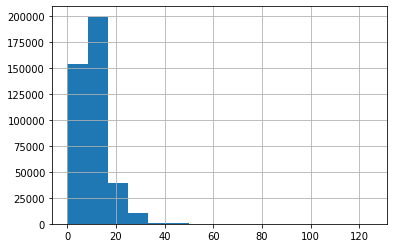

In [ ]:
df_train.question1.apply(lambda x: len(x.split())).hist(bins=15)

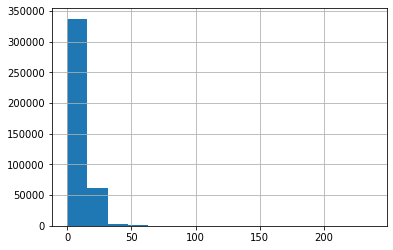

In [ ]:
df_train.question2.apply(lambda x: len(x.split())).hist(bins=15)

## Baseline (preprocess+tfidf+LogReg)

In [ ]:
def remove_stop_words(text):
    tokenized = text.split(' ')
    filtered = [word for word in tokenized if word not in stopwords.words('english')]
    return ' '.join(filtered)

In [ ]:
def text_process(text):
    text = text.lower()
    # удаляем пунктуацию
    text = re.sub(r'[^\w0-9\s]', '', text)
    # удаляем числа
    text = re.sub(r'\d+', '', text)
    text = remove_stop_words(text)
    return text

In [ ]:
df_train, df_test = train_test_split(df_train, test_size=0.25)

In [ ]:
df_train['q1_processed'] = df_train['question1'].apply(lambda x: text_process(x))
df_train['q2_processed'] = df_train['question2'].apply(lambda x: text_process(x))

df_test['q1_processed'] = df_test['question1'].apply(lambda x: text_process(x))
df_test['q2_processed'] = df_test['question2'].apply(lambda x: text_process(x))

In [ ]:
tfidf_vectorizer = FeatureUnion(
    [("tfidf", TfidfVectorizer(max_df=1., min_df=3)),
     ("tf", TfidfVectorizer(use_idf=False, ngram_range=(1, 2)))])

In [ ]:
tfidf = tfidf_vectorizer.fit(pd.concat([df_train['q1_processed'], df_train['q2_processed']]))

In [ ]:
X_train_q1_tfidf = tfidf_vectorizer.transform(df_train['q1_processed'])
X_train_q2_tfidf = tfidf_vectorizer.transform(df_train['q2_processed'])

In [ ]:
X_test_q1_tfidf = tfidf_vectorizer.transform(df_test['q1_processed'])
X_test_q2_tfidf = tfidf_vectorizer.transform(df_test['q2_processed'])

In [ ]:
y_train = df_train['is_duplicate']
y_test = df_test['is_duplicate']

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logit = LogisticRegression(C=5e1, solver='lbfgs', random_state=55)

In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy.sparse import hstack

In [ ]:
X_train = hstack((X_train_q1_tfidf, X_train_q2_tfidf))

In [ ]:
X_test = hstack((X_test_q1_tfidf, X_test_q2_tfidf))

In [ ]:
X_train

<303217x2286800 sparse matrix of type '<class 'numpy.float64'>'
	with 8958941 stored elements in COOrdinate format>

In [ ]:
logit.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=50.0, random_state=55)

In [ ]:
y_pred = logit.predict(X_test)

In [ ]:
f1_score(y_test, y_pred)

0.6693132417282881

## USE

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm

In [4]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
"""
USE не требует препроцессинга, поэтому получаем эмбеддинги на изначальных вопросах
"""

X_q1_train = df_train['question1'].tolist()
X_q2_train = df_train['question2'].tolist()

X_q1_emb = []
for q in tqdm(X_q1_train):
    emb = use([q])
    head_emb = tf.reshape(emb, [-1]).numpy()
    X_q1_emb.append(head_emb)

X_q1_emb = np.array(X_q1_emb)

100%|██████████| 303217/303217 [21:35<00:00, 234.10it/s]


In [ ]:
X_q2_emb = []
for q in tqdm(X_q2_train):
    emb = use([q])
    head_emb = tf.reshape(emb, [-1]).numpy()
    X_q2_emb.append(head_emb)

X_q2_emb = np.array(X_q2_emb)

100%|██████████| 303217/303217 [21:32<00:00, 234.68it/s]


In [ ]:
X_q1_test = df_test['question1'].tolist()
X_q2_test = df_test['question2'].tolist()

X_q1_emb_test = []
for q in tqdm(X_q1_test):
    emb = use([q])
    head_emb = tf.reshape(emb, [-1]).numpy()
    X_q1_emb_test.append(head_emb)

X_q1_emb_test = np.array(X_q1_emb_test)

100%|██████████| 101073/101073 [06:47<00:00, 247.97it/s]


In [ ]:
X_q2_emb_test = []
for q in tqdm(X_q2_test):
    emb = use([q])
    head_emb = tf.reshape(emb, [-1]).numpy()
    X_q2_emb_test.append(head_emb)

X_q2_emb_test = np.array(X_q2_emb_test)

100%|██████████| 101073/101073 [07:08<00:00, 236.02it/s]


В реальной задаче, на вход подается вопрос и нужно найти максимально похожие к нему, поэтому можно воспользоваться мерами сходства эмбеддингов (косинусное расстояние и т.д.) и затем подобрать порог, по которому будем считать эмбеддинги схожими. Для примера используем несходство Брея-Кертиса, которое лучше работает для эмбеддингов.

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
i = 0
bray_curtis = []
for _, row in df_train.iterrows():
    bray_curtis.append(1 - braycurtis(X_q1_emb[i], X_q2_emb[i]))
    i += 1

In [ ]:
# вычитаем из единицы, чтобы получить значения "больше - ближе"
i = 0
bray_curtis_test = []
for _, row in df_test.iterrows():
    bray_curtis_test.append(1 - braycurtis(X_q1_emb_test[i], X_q2_emb_test[i]))
    i += 1

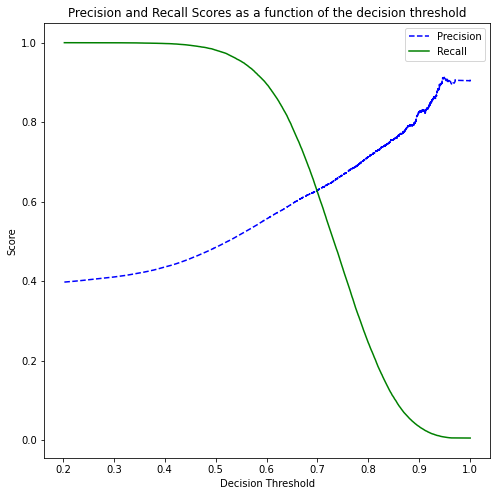

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, bray_curtis_test)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
y_pred = [1 if x > 0.6 else 0 for x in bray_curtis_test]

f1_score(y_test, y_pred)

0.6865260191118836

Добавим несхолдство, как доп фичу в классификатор

In [ ]:
X_train = np.concatenate((X_q1_emb, X_q2_emb, np.array(bray_curtis).reshape(303217, 1)), axis=1)
y_train = df_train['is_duplicate']

X_test = np.concatenate((X_q1_emb_test, X_q2_emb_test, np.array(bray_curtis_test).reshape(101073, 1)), axis=1)
y_test = df_test['is_duplicate']

In [ ]:
model = LinearSVC()

logit.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=50.0, random_state=55)

In [ ]:
y_pred = logit.predict(X_test)

f1_score(y_test, y_pred)

0.7130767872424238

## NN

Обучим простую трехслойную нейронную сеть на эмбеддингах предложений

In [10]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
import gc

from torch.optim import Adam

In [ ]:
tensor_x_train = torch.Tensor(X_train)
tensor_y_train = torch.Tensor(y_train.to_numpy(dtype=np.float64))
tensor_x_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test.to_numpy(dtype=np.float64))

tensor_x_train, tensor_x_val, tensor_y_train, tensor_y_val = train_test_split(tensor_x_train, tensor_y_train, test_size=0.25)

train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
val_dataset = TensorDataset(tensor_x_val, tensor_y_val)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [11]:
class EmbClassifier(nn.Module):
    def __init__(self):
        super(EmbClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(1024, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1), 
            nn.Sigmoid()
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [ ]:
def CalcValLoss(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y.unsqueeze(1))
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y.unsqueeze(1))
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLoss(model, loss_fn, val_loader)

In [ ]:
epochs = 8
learning_rate = 1e-4

loss_fn = nn.BCELoss()
emb_classifier = EmbClassifier()

optimizer = Adam(emb_classifier.parameters(), lr=learning_rate)

TrainModel(emb_classifier, loss_fn, optimizer, train_dataloader, val_dataloader, epochs)

100%|██████████| 3554/3554 [00:16<00:00, 209.18it/s]


Train Loss : 0.567
Valid Loss : 0.533
Valid F1  : 0.000


100%|██████████| 3554/3554 [00:13<00:00, 263.79it/s]


Train Loss : 0.501
Valid Loss : 0.482
Valid F1  : 0.000


100%|██████████| 3554/3554 [00:13<00:00, 266.19it/s]


Train Loss : 0.458
Valid Loss : 0.453
Valid F1  : 0.000


100%|██████████| 3554/3554 [00:13<00:00, 269.87it/s]


Train Loss : 0.428
Valid Loss : 0.431
Valid F1  : 0.000


100%|██████████| 3554/3554 [00:13<00:00, 257.64it/s]


Train Loss : 0.405
Valid Loss : 0.415
Valid F1  : 0.000


100%|██████████| 3554/3554 [00:15<00:00, 235.72it/s]


Train Loss : 0.385
Valid Loss : 0.403
Valid F1  : 0.000


100%|██████████| 3554/3554 [00:13<00:00, 263.29it/s]


Train Loss : 0.368
Valid Loss : 0.395
Valid F1  : 0.000


100%|██████████| 3554/3554 [00:13<00:00, 262.50it/s]


Train Loss : 0.354
Valid Loss : 0.389
Valid F1  : 0.000


In [ ]:
preds = emb_classifier(tensor_x_test)

In [ ]:
f1_score(y_test, [1 if x > 0.41 else 0 for x in preds.detach().numpy().squeeze(1)])

0.7633591589646496

In [ ]:
torch.save(emb_classifier.state_dict(), 'emb_classifier_3_linear_use_epoch_8.pth')

# Make submission

Test 1

In [6]:
df_submit_1 = pd.read_csv('test_1.csv.zip', compression='zip')
# test2_df = pd.read_csv('test_2.csv.zip', compression='zip')

In [7]:
df_submit_1.fillna('', inplace=True)

In [ ]:
del tensor_x_train, tensor_x_val, tensor_y_train, tensor_y_val

In [8]:
X_q1_train = df_submit_1['question1'].tolist()
X_q2_train = df_submit_1['question2'].tolist()

In [12]:
emb_classifier = EmbClassifier()
emb_classifier.load_state_dict(torch.load('emb_classifier_3_linear_use_epoch_8.pth'))

<All keys matched successfully>

In [23]:
import itertools

def grouper(iterable, n):
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

In [ ]:
preds = []

total = len(X_q1_train)//10000
for q1, q2 in tqdm(zip(grouper(X_q1_train, 10000), grouper(X_q2_train, 10000)), total=total):
    X_q1_emb = use(q1)
    X_q2_emb = use(q2)
    X_emb = tf.concat([X_q1_emb, X_q2_emb], 1)
    tensor_x = torch.Tensor(np.array(X_emb))
    preds.extend(emb_classifier(tensor_x).detach().numpy().squeeze(1).tolist())


In [30]:
preds = [1 if x > 0.41 else 0 for x in preds]

In [33]:
df_submit_1['is_duplicate'] = preds
df_submit_1.to_csv('submit_test_1.csv', columns=['test_id', 'is_duplicate'], index=False)

Test 2

In [34]:
df_submit_1 = pd.read_csv('test_2.csv.zip', compression='zip')
# test2_df = pd.read_csv('test_2.csv.zip', compression='zip')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [35]:
df_submit_1.fillna('', inplace=True)

In [36]:
X_q1_train = df_submit_1['question1'].tolist()
X_q2_train = df_submit_1['question2'].tolist()

In [37]:
preds = []

total = len(X_q1_train)//10000
for q1, q2 in tqdm(zip(grouper(X_q1_train, 10000), grouper(X_q2_train, 10000)), total=total):
    X_q1_emb = use(q1)
    X_q2_emb = use(q2)
    X_emb = tf.concat([X_q1_emb, X_q2_emb], 1)
    tensor_x = torch.Tensor(np.array(X_emb))
    preds.extend(emb_classifier(tensor_x).detach().numpy().squeeze(1).tolist())

357it [15:47,  2.66s/it]


In [38]:
preds = [1 if x > 0.41 else 0 for x in preds]

In [39]:
df_submit_1['is_duplicate'] = preds
df_submit_1.to_csv('submit_test_2.csv', columns=['test_id', 'is_duplicate'])